# Blackjack 

We consider a slightly simplified version of **blackjack** in which a **player** plays against the **dealer**. Both agents (**player** and **dealer**) start with a single card. The **player** first take his turns, and then (once the player is finished) the **dealer** may play (unless the player was _busted_, in which case the dealer authomatically wins, and need not play).

In each turn, an agent may choose two actions: **HIT** or **HOLD**. By choosing **HIT**, the agent is asking for one more card from the deck. By choosing **HOLD**, the agent finishes his turn without drawing an additional card.

The agent **total** is the sum of **values** of all cards the agent has drawn, including the initial card handed to it on the start of the game. The "small cards" (2, 3, 4, ..., 9, 10) have the value equal to their number. The "face cards" (J, Q, K) have value 10. Ace (A) can have two values: 1 or 11, depending on the choice of the agent.

THE GOAL OF THE GAME IS TO HAVE THE HIGHEST TOTAL NOT BIGGER THAN 21. If an agent achieves the total bigger than 21 it losses the game (we say that the agent is _busted_ in this case). More precisely:

* If the player is busted, dealer wins.
* If the players is not busted, then:
  - If the dealer is busted, player wins.
  - If the dealer is not busted, the agent with the highest total wins.
  - In case that neither agent is busted, and both have the same total, the game is draw.
 
Upon playing each game, the wining agent receives reward +1, the losing agent receives -1. If the game is draw, both agents receive 0. The reward is given only when the game is over. No reward is received after non-terminating actions (the reward following those actions is 0).

<div class="alert alert-block alert-info">
<b>The Assignment:</b> 
Train a bot able to play blackjack agains the dealer.
</div>

<div class="alert alert-block alert-warning">
<b>Dealer strategy:</b> 
    Assume that the dealer is playing according to a fixed strategy: Choose HIT as long as the dealer total is not above 17, otherwise choose HOLD.
</div>

## Basic Imports

In [1]:
from enum import Enum
from dataclasses import dataclass, astuple
from typing import Callable
from random import random, randint
from copy import deepcopy

from tqdm import trange
from rich import print

import numpy as np
import matplotlib.pyplot as plt

## Cards and Decks of Cards

Let us first implement cards and decks of cards.

In [2]:
class CardSuit(Enum):
    """An enumeration representing card suits."""
    
    DIAMONDS = 0
    CLUBS = 1
    HEARTS = 2
    SPADES = 3

    def __repr__(self):
        match self:
            case CardSuit.DIAMONDS:
                return "♦"
            case CardSuit.CLUBS:
                return "♣"
            case CardSuit.HEARTS:
                return "♥"
            case CardSuit.SPADES:
                return "♠"

In [3]:
class CardValue(Enum):
    """An enumeration representing card values."""

    ACE = 1
    TWO = 2
    THREE = 3
    FOUR = 4
    FIVE = 5
    SIX = 6
    SEVEN = 7
    EIGHT = 8
    NINE = 9
    TEN = 10
    JACK = 12
    DAME = 13
    KING = 14

    def __repr__(self):
        if self == CardValue.ACE:
            return "A"
        elif self.value >= 2 and self.value <= 10:
            return str(self.value)
        elif self == CardValue.JACK:
            return "J"
        elif self == CardValue.DAME:
            return "D"
        elif self == CardValue.KING:
            return "K"

A card is completely defined by a combination of face and suit. We could implement cards as tuples. However, we will implement a separate class for this, solely in order to have a nice, natural representation of cards as string.

To get the best of both worlds, we will create a card class a _dataclass_!

In [4]:
@dataclass
class Card:
    """A playing card."""
    value: CardValue
    suit: CardSuit

    def __repr__(self):
        return f"{repr(self.value)}{repr(self.suit)}"

Just to illustrate, let us create a card and see how nicely it is written to the console.

In [5]:
Card(value=CardValue.ACE, suit=CardSuit.HEARTS)

A♥

Once we have implemented individual cards, we may proceede to implement a deck.

In [6]:
class CardDeck:
    """A deck of cards.

    The deck contains 52 playing cards, which are shuffled and drawn consecutively.
    Once all cards have been drawn, the deck reshuffles automatically.
    """

    def reshuffle(self):
        self.cards = [Card(value=v, suit=s) for v in iter(CardValue) for s in iter(CardSuit)]
        np.random.shuffle(self.cards) 

    def __init__(self):
        self.reshuffle()

    def draw(self):
        if not self.cards:
            self.reshuffle()
        return self.cards.pop(0)

In [7]:
# These few lines simply visualize random card ordering in a deck.
deck = CardDeck()
print(", ".join([repr(c) for c in deck.cards]))

J♣, 7♣, D♦, K♦, 7♦, 9♠, 10♦, 3♣, 2♥, 6♣, 3♦, 7♠, 8♦, 2♣, 6♦, 9♥, 9♦, K♥, 5♣, J♥, 5♠, D♠, A♣, A♦, 4♠, 5♦, A♠, 10♥, 
J♦, 4♣, A♥, 6♠, D♥, 7♥, 4♦, 10♠, 8♥, 5♥, 8♠, 4♥, K♠, 6♥, 3♠, 8♣, 10♣, 3♥, D♣, 2♠, K♣, 9♣, 2♦, J♠

## Blackjack State and Rules for Updating the State

We now proceede to implement the state of a blackjack game, as well as different policies.

From the position of a player, the **state** of a blackjack game is defined by the list of all cards it has previously drawn (including the card that was initially given to it) and also the card in the posession of the dealer. However, the state defined in such a way actually contains more information than is actually needed to form a decission. It is sufficient to know:
* the current player total;
* if this total is created using an ACE which can be converted to 1, if needed; and
* the value of the dealer's card

As before, we utilize the concept of `dataclass` in order to implement the `State`.

In [8]:
@dataclass
class State:
    total: int
    has_ace: bool
    dealer_total: int

    def __hash__(self):
        return hash(astuple(self))

We will now define a function which updates the total once the new card is drawn. In a way, this function implements core of the blackjack playing rules.

In [9]:
def update_total(total: int, has_ace: bool, card_value: CardValue) -> tuple[int, bool]:
    """Update (a portion of) the player state by taking account a newly drawn card.
    
    Given the information regarding the current player state (total and ACE info), and the
    value of a newly drawn card, updates the current player state (both total and ACE info).

    The updated total returned by this function can be bigger than 21.
    The function correctly tracks statuses of ACEs (i.e. it changes values of ACEs from
    11 to 1, when appropriate, in order for the total not to excede 21), however, if
    after this the total still remains bigger than 21 the function will simply return it
    as is.

    Args:
        total (int): player total
        has_ace (bool): indicates if the player has usable ACE
        card_value (CardValue): value of the newly drawn card

    Returns:
        int: updated player total
        bool: updated info indicating if the player has a usable ACE
    """
    if card_value == CardValue.ACE:
        if total + 11 <= 21:
            # We have an ACE and the total is less than 21.
            # We can keep the ACE as 11.
            # Notice that it was impossible that we had another ACE in posession
            # before (since in that case the total would surely be bigger than 21)
            return (total+11, True)
        else:
            # The total excedes 21, and we must count the ACE as 1.
            # It is possible we had another active ACE before, if so the
            # status of this old ACE does not change.
            return (total+1, has_ace)
    else:
        total += min(card_value.value, 10)
        if total > 21:
            # The player is potentially busted.
            if has_ace:
                # If we have an active ACE, we are saved.
                # The ACE value is reduced from 11 to 1 (and the total is reduced by 10).
                # However, the cost is that we no longer have an active ACE.
                total -= 10
                return (total, False)
            else:
                # We have not active ACE, so we cannote decrease the total
                return (total, has_ace)
        # The total is less than 21, we may return the state as is.
        return (total, has_ace)

Another usefull function will be the one that generates a random state. A valid Blackjack state is any in which the player total is between 2 and 21 (1 is never the total, since it could only happen by having a single ACE, which would be counted by 11). ACE indication can be `True` only if the total is bigger or equal to 11. Further, since the dealer has only one card during a player's turn, possible card values are between 2 and 11. 

In [10]:
def random_state() -> State:
    """Generate a random state."""
    total = randint(2, 21)
    if total>= 11:
        r = random()
        if r >= 0.5:
            has_ace = True
        else:
            has_ace = False
    else:
        has_ace = False
    dealer_value = randint(2, 11)
    return State(total, has_ace, dealer_value)

In [11]:
def all_states() -> list[State]:
    """Create a list of all possible Blackjack states."""
    states = []
    for total in range(2, 22):
        for dealer_value in range(2, 12):
            states.append(State(total, False, dealer_value))
            if total >= 11:
                states.append(State(total, True, dealer_value))
    return states

In [12]:
states = all_states()
len(states)

310

## Blackjack Actions and Policies

We are now ready to define some interesting Blackjack policies. Before doing that, we will need to define Blackjack actions.

In [13]:
class Action(Enum):
    """Blackjack action."""
    HIT = 0
    HOLD = 1

    def __str__(self):
        return "HIT" if self == Action.HIT else "HOLD"

In [14]:
def random_action() -> Action:
    """Return random action."""
    r = random()
    if r <= 0.5:
        return Action.HIT
    else:
        return Action.HOLD

A policy can be seen as a function which, given a state, returns the action to take. Let us first define a type to describe all actions (so that we can use it in signatures of functions and methods).

In [15]:
Policy = Callable[[State], Action]

Let us first define a **random policy**: A player using this policy will choose an action at random regardless of the state.

In [16]:
def random_policy(s: State) -> Action:
    return random_action()

Another interesting policy is the **delaer policy**: Choose HIT whenever the total is less than 17, otherwise play HOLD.

In [17]:
def dealer_policy(s: State) -> Action:
    total, has_ace, _ = astuple(s)
    if total < 17:
        return Action.HIT
    else:
        return Action.HOLD

## Using a Policy: Playing an Entire Turn (of a Player or a Dealer)

We now proceed to implement a single **turn**. This will be used to identify a sequence of HIT actions of a single agent, starting from some given initial state until a HOLD action is selected, or the total excedes 21. One Blackjack game (the way we are playing it here) consists of two turns: the player's turn and the dealer's turn. So, once we implement the turn, we will be able to implement a single game. A path to implementing a learning agent will then be completely set.

In general, we will be "playing" games in several different scenarios. In cases we are learning, we will be interested in "playing" many (thousands and tens of thousands) of games silently. In other cases, particularly during testing and demonstration, we will be interested in carefully tracing each event within a single game. 

To make reporting functionality flexibile, we will add a single optional argument to out "turn-playing" and "game-playing" functions -- report callback. It will be a function which takes a textual message and reports and (optionally) reports it to a user.

In [18]:
ReportCallback = Callable[[str], None]

Another interesting point to note is that we will wish to "play" games starting from different initial states. During learning, it will be of interest to choose the initial state completely randomly. During demonstration, it will be more interesting to have the game start in the usual way: by drawing a card from the deck for the player and another card from the deck for the dealer.

In [19]:
def get_init_state(state: State | str | None, deck: CardDeck) -> State:
    if state is None:
        player_card = deck.draw()
        total, has_ace = update_total(0, False, player_card.value)
        dealer_card = deck.draw()
        dealer_value = min(dealer_card.value.value, 10)
        return State(total, has_ace, dealer_value)
    else:
        if isinstance(state, str):
            assert state == "random", f"Invalid init state specification: '{state}'"
            return random_state()
        else:
            return state

Similarly, we may wish to simulate a turn with a fixed given initial action, or with the initial action determined by the decision policy.

In [20]:
def get_init_action(action: Action | str | None, state: State, policy: Policy) -> Action:
    if action is not None:
        if isinstance(action, str):
            assert action == "random", f"Ivalid init action specification: '{action}'"
            return random_action()
        else:
            return action
    else:
        return policy(state)

Finally, we are ready to implement a single turn of play... While playing we will track the sequence of states and actions We will need those information later, while implementing learning agents.

In [21]:
TurnLog = list[tuple[State, Action]]

In [22]:
def play_turn(policy: Policy, 
              deck: CardDeck, 
              init_state: State | None = None,
              init_action: Action | None = None, 
              report_callback: ReportCallback | None = None) -> tuple[int | None, TurnLog]:
    """A single playing turn of an agent.

    Args:
        policy (Policy): decision policy used by the agent
        deck (CardDeck): deck of cards from which to draw
        init_state (State | None): initial state or `None` if the initial state
                                   is to be selected by drawing from the deck.
        init_action (Action | None): initial action or `None` if the initial action
                                     is to be selected according to the decision policy
        report_callback (ReportCallback | None): callback used to report progress
                                                 if `None`, the turn will be played silently

    Return:
        int | None: The final agent's total or `None` if the agent is busted
        TurnLog: sequence of states and actions observed during gameplay
    """
    report = lambda txt: report_callback and report_callback(txt)
    state = get_init_state(init_state, deck)
    action = get_init_action(init_action, state, policy)
    total, has_ace, dealer_value = astuple(state)
    report(f"[bold]initial state[/] {state}")
    report(f"initial total {total} with ACE {has_ace} => [bold]initial action[/] {action}")
    turn_log = [(state, action)]
    while action == Action.HIT:
        card = deck.draw()
        total, has_ace = update_total(total, has_ace, card.value)
        state = State(total, has_ace, dealer_value)
        if total > 21:
            # Since total is above 21, the state is not valid and should not
            # be logged!
            report(f"turned finished - [bold]BUSTED![/] card drawn {card} => total {total} with ACE {has_ace}")
            return None, turn_log
        else:
            action = policy(state)
            turn_log.append((state, action))
            report(f"card drawn {card} => total {total} with ACE {has_ace} => action chosen {action}")
    report(f"turn finished with final total {total}")
    return total, turn_log

We can now test the functionality implemented thus far...

In [23]:
report_callback = lambda txt: print(f"[bold blue]AGENT:[/] {txt}")

In [24]:
# When not specifying the initial state, one will be selected at random!
# When also not specifying the initial action, one will be choses according 
# to the given policy for the initial state
play_turn(random_policy, deck, report_callback=report_callback)

AGENT: initial state State(total=10, has_ace=False, dealer_total=7)

AGENT: initial total 10 with ACE False => initial action HOLD

AGENT: turn finished with final total 10

(10, [(State(total=10, has_ace=False, dealer_total=7), <Action.HOLD: 1>)])

In [25]:
# When not specifying the initial state, one will be selected at random!
# When also not specifying the initial action, one will be choses according 
# to the given policy for the initial state
play_turn(dealer_policy, deck, report_callback=report_callback)

AGENT: initial state State(total=10, has_ace=False, dealer_total=10)

AGENT: initial total 10 with ACE False => initial action HIT

AGENT: card drawn 7♦ => total 17 with ACE False => action chosen HOLD

AGENT: turn finished with final total 17

(17,
 [(State(total=10, has_ace=False, dealer_total=10), <Action.HIT: 0>),
  (State(total=17, has_ace=False, dealer_total=10), <Action.HOLD: 1>)])

In [26]:
# If we like, we can force the initial action.
# Subsequent actions will be selected according to the given policy.
play_turn(dealer_policy, deck, init_action=Action.HOLD, report_callback=report_callback)

AGENT: initial state State(total=9, has_ace=False, dealer_total=10)

AGENT: initial total 9 with ACE False => initial action HOLD

AGENT: turn finished with final total 9

(9, [(State(total=9, has_ace=False, dealer_total=10), <Action.HOLD: 1>)])

In [27]:
# If we like, we may also require the initial action to be selected at random
# Subsequent actions will be selected according to the given policy.
play_turn(dealer_policy, deck, init_action="random", report_callback=report_callback)

AGENT: initial state State(total=3, has_ace=False, dealer_total=2)

AGENT: initial total 3 with ACE False => initial action HOLD

AGENT: turn finished with final total 3

(3, [(State(total=3, has_ace=False, dealer_total=2), <Action.HOLD: 1>)])

## Using a Policy: Playing an Entire Game

We will now implement a function that will be used to play entire games. In addition to playing the game, the function will also collect experience - tripples containing states, actions, and the total discounted reward - collected during play.

In [28]:
Experience = tuple[State, Action, float]

We will first a need some auxiliary functionality that computes discounted gains from rewards, and builds experience from player's turn log.

In [29]:
def compute_gain(rewards: list[float], gamma: float) -> float:
    """
    Compute the total gain given the list of future rewards.
    
    Args:
        rewards (list[float]): List of future rewards.
        gamma: discount factor

    Returns:
        float: The total gain
    """
    g = 0
    w = 1
    for r in rewards:
        g += w*r
        w *= gamma
    return g

def discounted_gains(rewards: list[float], gamma) -> list[float]:
    """
    Compute list of discounted gains, given a sequence of rewards.

    Args:
        rewards (list[float]): Sequence of rewards.
        gamma: discount factor

    Returns:
        list[float]: sequence of gains
    """
    gains = [compute_gain(rewards[i:], gamma) for i in range(len(rewards))]
    return gains

def build_experience(turn_log: TurnLog, result: int, gamma) -> Experience:
    rewards = [0 for _ in turn_log]
    rewards[-1] = result
    gains = discounted_gains(rewards, gamma)
    exp = [(s, a, g) for (s, a), g in zip(turn_log, gains)]
    return exp

Let us see how the above functions work first.

In [30]:
rewards = [0, 0, 0, 1]

In [31]:
discounted_gains(rewards, 1.0)

[1.0, 1.0, 1.0, 1]

In [32]:
discounted_gains(rewards, 0.9)

[0.7290000000000001, 0.81, 0.9, 1]

We are now ready to actually implement the function to play games...

In [33]:
def play_game(policy: Policy, 
              deck: CardDeck, 
              init_state: State | None = None,
              init_action: Action | str | None = None,
              gamma : float = 1.0,
              game_report_callback: ReportCallback | None = None,
              player_report_callback: ReportCallback | None = None,
              dealer_report_callback: ReportCallback | None = None) -> tuple[int, Experience]:
    report = lambda txt: game_report_callback and game_report_callback(txt)
    state = get_init_state(init_state, deck)
    action = get_init_action(init_action, state, policy)
    player_total, turn_log = play_turn(policy, deck, init_state=state, init_action=action, report_callback=player_report_callback)
    if player_total is not None:
        dealer_card = CardValue(state.dealer_total) if state.dealer_total != 11 else CardValue.ACE
        dealer_total, dealer_has_ace = update_total(0, False, dealer_card)
        dealer_state = State(dealer_total, dealer_has_ace, 0)
        dealer_total, _ = play_turn(dealer_policy, deck, init_state=dealer_state, report_callback=dealer_report_callback)
        if dealer_total is not None:
            if player_total > dealer_total:
                result = +1
            elif player_total == dealer_total:
                result = 0
            else:
                result = -1
        else:
            result = +1
    else:
        result = -1
    exp = build_experience(turn_log, result, gamma)
    if result == 1:
        report("Player WINS")
    elif result == 0:
        report("Game DRAW")
    else:
        report("Player LOSES")
    return result, exp

In order to test it, let us define some handy report callbacks

In [34]:
player_report_callback = lambda txt: print(f"[bold blue]PLAYER:[/] {txt}")
dealer_report_callback = lambda txt: print(f"[bold cyan]DEALER:[/] {txt}")
game_report_callback = lambda txt: print(f"[bold red]{txt}[/]")

callbacks = {
    "player_report_callback": player_report_callback,
    "dealer_report_callback": dealer_report_callback,
    "game_report_callback": game_report_callback
}

Let us play a bit with the two above-defined policies. Later we will show that the dealer policy is considerably more meaningfull than the random one (as expected!)

In [35]:
play_game(random_policy, deck, **callbacks)

PLAYER: initial state State(total=6, has_ace=False, dealer_total=3)

PLAYER: initial total 6 with ACE False => initial action HOLD

PLAYER: turn finished with final total 6

DEALER: initial state State(total=3, has_ace=False, dealer_total=0)

DEALER: initial total 3 with ACE False => initial action HIT

DEALER: card drawn 7♠ => total 10 with ACE False => action chosen HIT

DEALER: card drawn 8♦ => total 18 with ACE False => action chosen HOLD

DEALER: turn finished with final total 18

Player LOSES

(-1, [(State(total=6, has_ace=False, dealer_total=3), <Action.HOLD: 1>, -1)])

In [36]:
play_game(dealer_policy, deck, **callbacks)

PLAYER: initial state State(total=2, has_ace=False, dealer_total=6)

PLAYER: initial total 2 with ACE False => initial action HIT

PLAYER: card drawn 9♥ => total 11 with ACE False => action chosen HIT

PLAYER: card drawn 9♦ => total 20 with ACE False => action chosen HOLD

PLAYER: turn finished with final total 20

DEALER: initial state State(total=6, has_ace=False, dealer_total=0)

DEALER: initial total 6 with ACE False => initial action HIT

DEALER: card drawn K♥ => total 16 with ACE False => action chosen HIT

DEALER: card drawn 5♣ => total 21 with ACE False => action chosen HOLD

DEALER: turn finished with final total 21

Player LOSES

(-1,
 [(State(total=2, has_ace=False, dealer_total=6), <Action.HIT: 0>, -1.0),
  (State(total=11, has_ace=False, dealer_total=6), <Action.HIT: 0>, -1.0),
  (State(total=20, has_ace=False, dealer_total=6), <Action.HOLD: 1>, -1)])

Finally, let us define a function that will enable us to apply (and test) different policies. This function will play many games, collect experience and compute the ratio of wins, draws, and losses.

But first, we must define **experience** more precisely! Experience is a list of states, actions and gains seen during playtime. In otherwords, to each state-action pair seen in each turn we must associate the total gain received during that game from this point on (possibly discounted by a suitable discount factor - $\gamma$)

In [37]:
@dataclass
class PolicyTestingResult:
    games_no: int
    score: int
    wins: float
    draws: float
    losses: float

    def __repr__(self):
        return f"total score={self.score}/{self.games_no} games ({self.score / self.games_no:.4f} per game) :: W {self.wins*100:.2f}% | D {self.draws*100:.2f}% | L {self.losses*100:.2f}%"

We will make two different methods for evaluating policies. The first one chooses initial states and actions randomly in each run. The second one repeatedly enumerates through all possible states and all possible actions, and uses all possible combinations of the initial state-action pair. The enumerated version is possible only because the number of states in (this version of) Blackjack is not high.

In [38]:
def apply_policy(policy: Policy, deck: CardDeck, games_no=1000, gamma=1, random_init_state=False, random_init_action=False) -> tuple[PolicyTestingResult, Experience]:
    wins, losses, draws, score = 0, 0, 0, 0
    init_action = "random" if random_init_action else None
    init_state = "random" if random_init_state else None
    experience = []
    for k in range(games_no):
        res, exp = play_game(policy, deck, gamma=gamma, init_action=init_action)
        score += res
        experience.extend(exp)
        if res == 1:
            wins += 1
        elif res == 0:
            draws += 1
        else:
            losses += 1
    return PolicyTestingResult(games_no, score, wins/games_no, draws/games_no, losses/games_no), experience

In [39]:
def apply_policy_exhaustive(policy: Policy, deck: CardDeck, epoch_no=5, gamma=1) -> tuple[PolicyTestingResult, Experience]:
    wins, losses, draws, score, games_no = 0, 0, 0, 0, 0
    experience = []
    for k in range(epoch_no):
        for s0 in all_states():
            for a0 in [Action.HIT, Action.HOLD]:
                res, exp = play_game(policy, deck, gamma=gamma, init_state=s0, init_action=a0)
                games_no += 1
                score += res
                experience.extend(exp)
                if res == 1:
                    wins += 1
                elif res == 0:
                    draws += 1
                else:
                    losses += 1
    return PolicyTestingResult(games_no, score, wins/games_no, draws/games_no, losses/games_no), experience            

Let us test the above function by playing just five games, to see what kind of objects it returns. The actual tests require many more games to be played, and this will be done shortly after.

In [40]:
res = apply_policy(random_policy, deck, 5, gamma=0.9)
print(res)

(
    total score=-1/5 games (-0.2000 per game) :: W 40.00% | D 0.00% | L 60.00%,
    [
        (State(total=10, has_ace=False, dealer_total=5), <Action.HOLD: 1>, -1),
        (State(total=4, has_ace=False, dealer_total=5), <Action.HIT: 0>, -0.81),
        (State(total=15, has_ace=True, dealer_total=5), <Action.HIT: 0>, -0.9),
        (State(total=15, has_ace=False, dealer_total=5), <Action.HOLD: 1>, -1),
        (State(total=11, has_ace=True, dealer_total=6), <Action.HOLD: 1>, 1),
        (State(total=4, has_ace=False, dealer_total=10), <Action.HOLD: 1>, -1),
        (State(total=5, has_ace=False, dealer_total=8), <Action.HIT: 0>, 0.81),
        (State(total=9, has_ace=False, dealer_total=8), <Action.HIT: 0>, 0.9),
        (State(total=19, has_ace=False, dealer_total=8), <Action.HOLD: 1>, 1)
    ]
)

## Comparative Performance of the Random and Dealer's Policy (when used by the Player)

Now, we are ready to perform the actual testing. We will test both previously defined policies: the purely explorative random policy and (probably near optimal) dealer's policy. The measurement will be performed by both previously defined functions.

In [41]:
res, _ = apply_policy(random_policy, deck, 10000)
print(res)

total score=-4175/10000 games (-0.4175 per game) :: W 28.07% | D 2.11% | L 69.82%

In [42]:
res, _ = apply_policy(dealer_policy, deck, 10000)
print(res)

total score=-732/10000 games (-0.0732 per game) :: W 41.31% | D 10.06% | L 48.63%

We see that the player using the same strategy as the dealer losses about 0.08 "points" per game. It losses only slightly below 50% of the time, byt manages to win in only slightly above 40% of the cases. The difference in gains between the actual dealer and the player acting as a dealer is due to the inherent assymetry of the game, and the fact that the dealer plays second, only after the player ended its turn, and only if the player is not busted!

The similar behavior may be observed when testing wiht completely random init state

In [43]:
res, _ = apply_policy(random_policy, deck, 10000, random_init_state=True)
print(res)

total score=-4186/10000 games (-0.4186 per game) :: W 28.03% | D 2.08% | L 69.89%

In [44]:
res, _ = apply_policy(dealer_policy, deck, 10000, random_init_state=True)
print(res)

total score=-867/10000 games (-0.0867 per game) :: W 40.39% | D 10.55% | L 49.06%

... and also when using exhaustive testing

In [45]:
res, _ = apply_policy_exhaustive(random_policy, deck, gamma=0.9)
print(res)

total score=-921/3100 games (-0.2971 per game) :: W 33.00% | D 4.29% | L 62.71%

In [46]:
res, _ = apply_policy_exhaustive(dealer_policy, deck, gamma=0.9)
print(res)

total score=-567/3100 games (-0.1829 per game) :: W 37.58% | D 6.55% | L 55.87%

We see that (qualitatively) the same performance is observed when using the exhaustive testing procedure. The later results should be considered more representative, since they are taking into account all possible state-action pairs.

## Learning a Decision Policy

In order to learn a decision policy, we will first implement a policy which is greedy with respect to a given Q-function. In this particular case, the Q-function will be implemented as a dictionary which returns a pair of value: the Q-value corresponding to HIT action, and the Q-value corresponding to HIT action. 

If the Q-dictionary does not contain an entry for a given state, a random action will be returned. Otherwise, the action with the higher Q-value will be used. If some Q-values returned for the given state are missing (equal to `None`) random policy will be used. If the length of the retyrned array is different than expected, an error will be raised.

In [47]:
QDict = dict[State, tuple[float, float]]

def create_greedy_policy(q_dict: QDict):
    """Create a policy function from the given Q-dictionary."""
    no_actions = len(list(Action))

    def policy(s: State):
        q_values = q_dict.get(s, None)
        if q_values is not None:
            assert len(q_values) == no_actions, f"Invalid Q-dict for state {s}."
            if any([v is None for v in q_values]):
                return random_policy(s)
            else: 
                ndx = np.argmax(q_values)
                return Action(ndx)
        else:
            return random_policy(s)
    
    return policy

Now we need a function that will evaluate Q-dictionary based on the collected experience.

In [48]:
def evaluate_Q(experience):
    gains_dict = dict()
    for s, a, g in experience:
        action_gains = gains_dict.get(s, ([], []))
        action_gains[a.value].append(g)
        gains_dict[s] = action_gains

    q_dict = dict()
    for s, g_values in gains_dict.items():
        q_values = []
        for ga in g_values:
            if not ga:
                q_values.append(None)
            else:
                q_values.append(np.mean(ga))
        q_dict[s] = q_values
    return q_dict

In [49]:
q_dict = dict()
policy = create_greedy_policy(q_dict)
res, exp = apply_policy(policy, deck, 100000, gamma=0.9, random_init_action=True)
print(res)
q_dict = evaluate_Q(exp)
# print([s for s, q in q_dict.items() if q[0] is None or q[1] is None])

total score=-41470/100000 games (-0.4147 per game) :: W 28.23% | D 2.06% | L 69.70%

In [50]:
policy = create_greedy_policy(q_dict)
res, exp = apply_policy(policy, deck, 100000, gamma=0.9, random_init_action=True)
print(res)
q_dict = evaluate_Q(exp)
# print([s for s, q in q_dict.items() if q[0] is None or q[1] is None])

total score=-27117/100000 games (-0.2712 per game) :: W 34.83% | D 3.22% | L 61.95%

In [51]:
len([s for s, q in q_dict.items() if q[0] is None or q[1] is None])/len(q_dict)

0.6742671009771987

In [52]:
policy = create_greedy_policy(q_dict)
res, exp = apply_policy(policy, deck, 100000, gamma=0.9, random_init_action=True, random_init_state=True)
print(res)
q_dict = evaluate_Q(exp)
len([s for s, q in q_dict.items() if q[0] is None or q[1] is None])/len(q_dict)

total score=-41194/100000 games (-0.4119 per game) :: W 28.27% | D 2.27% | L 69.46%

0.0

In [53]:
q_dict = dict()
results = []
for k in trange(40):
    policy = create_greedy_policy(q_dict)
    res, exp = apply_policy(policy, deck, 10000, gamma=0.9, random_init_action=True, random_init_state=True)
    results.append(res)
    q_dict = evaluate_Q(exp)

100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:16<00:00,  2.47it/s]


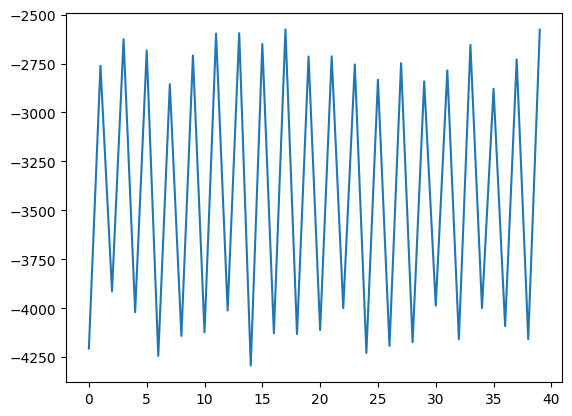

In [54]:
plt.plot([r.score for r in results])

In [55]:
q_dict = dict()
q_dict_best = dict()
res_best = - float("inf")
results = []
for k in trange(40):
    policy = create_greedy_policy(q_dict)
    res, exp = apply_policy_exhaustive(policy, deck, gamma=0.9, epoch_no=20)
    results.append(res)
    if res.score > res_best:
        q_dict_best = deepcopy(q_dict)
        res_best = res.score
    q_dict = evaluate_Q(exp)

100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:18<00:00,  2.16it/s]


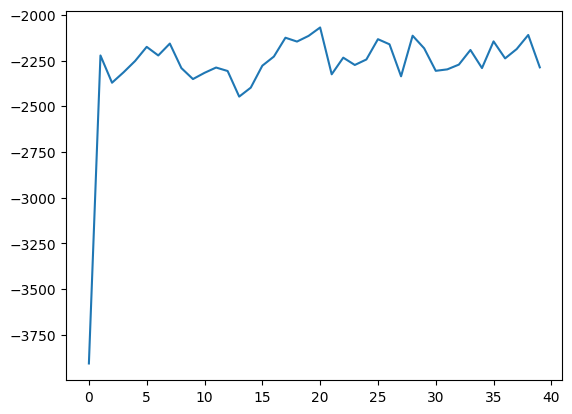

In [56]:
plt.plot([r.score for r in results])

In [57]:
res_best

-2069

In [58]:
res, _ = apply_policy_exhaustive(create_greedy_policy(q_dict_best), deck, gamma=0.9, epoch_no=20)
print(res)

total score=-2276/12400 games (-0.1835 per game) :: W 38.06% | D 5.52% | L 56.42%

In [59]:
res, _ = apply_policy_exhaustive(dealer_policy, deck, gamma=0.9, epoch_no=20)
print(res)

total score=-2130/12400 games (-0.1718 per game) :: W 38.13% | D 6.56% | L 55.31%